In [1]:
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import pandas as pd  
import numpy as np  

import tools.Sample_Tools as smpl
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)


import matplotlib.pyplot as plt
import seaborn as sns

from base.JuUnits import parallal_task,task_chunk_split
from base.JuUnits import excute_for_multidates

# import statsmodels.api as sm

from sklearn.decomposition import FactorAnalysis

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

# import inspect
import warnings


# from sklearn import linear_model
# import ind.alpha101 as a101


In [2]:
###加载数据

ids = np.arange(1,101)
# np.random.shuffle(ids)
files = list(map(lambda x:'alpha'+str(x)+'_train',ids))

def load_alpha_factors(file_names):
    from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)
    from base.JuUnits import excute_for_multidates
    import numpy as np
    import pandas as pd 
    
    temp = []
    for file in file_names:
        print(file)
        temp.append(load_cache(file, cache_type=CACHE_TYPE.FACTOR))
    
    return pd.concat(temp,axis=1)
        
worker=6
task = task_chunk_split(files, worker)
results = parallal_task(worker, load_alpha_factors, task)
a101 = pd.concat(results,axis=1)

Now in the main code. Process name is: base.JuUnits
base.JuUnits, subpid:24652  pid:6004


  0%|          | 0/6 [00:00<?, ?it/s]

D:\Anaconda3\lib\site-packages\pandas\core\nanops.py:892: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


init
600010  skip!! value: 0.5779975632625689
600519  skip!! value: nan
600989  skip!! value: nan
601236  skip!! value: nan
601658  skip!! value: nan
601698  skip!! value: nan


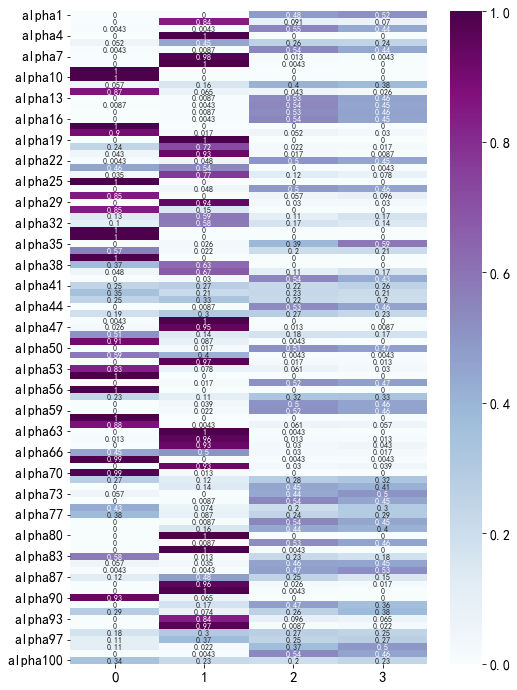

In [4]:
codes = smpl.get_codes_by_zs('沪深300')
n_factors = 4

excluded = a101.columns.difference(['alpha27','alpha61','alpha68','alpha75','alpha86','alpha95'],sort=False) 
selected = a101.loc[(slice('2016-01-04','2020-12-24'),codes),:][excluded].dropna()
selected_standard = excute_for_multidates(selected,lambda x:(x-x.mean())/x.std(), level=1)

fa = FactorAnalyzer(n_factors,rotation='promax',method='minres')
res = np.zeros((len(selected.columns),n_factors)) #记录因子载荷“累积”
statistic = [] #记录每个标的跑出来的载荷，并把载荷转换为“id”，用作最后统计


def mixing_fa(cum_res,new_res):
    n_factors = new_res.shape[1]
    
    if not cum_res.any():
        cum_res+=new_res
        print('init')
        print('===========')
        return
    
    cum_unmatch_cols = list(range(n_factors))
    blank_stat = np.zeros_like(new_res)
    for i_col in range(n_factors):
        new_col = new_res[:,i_col]
        if len(cum_unmatch_cols)>1:
            max_index = np.argmax([np.corrcoef(new_col, cum_res[:,j_col])[0][1] for j_col in cum_unmatch_cols])
            match_col_index = cum_unmatch_cols[max_index]
            cum_unmatch_cols.pop(max_index)
        else:
            match_col_index = cum_unmatch_cols[0]
        # 累计的载荷，用于后续因子分析结果对其
        cum_res[:,match_col_index] = cum_res[:,match_col_index]*.5 + new_col*.5
        # 对齐后的当前标的载荷
        blank_stat[:,match_col_index] = blank_stat[:,match_col_index] + new_col
    
    # 对齐后的当前标的载荷，转换为“因子下标”，记录到全局
    global statistic
    statistic.append(blank_stat.argmax(axis=1))

print_count=-1
def cum_fa(single_stock_df,result):
    global print_count
    print_count+=1
    
    df = single_stock_df.reset_index('code',drop=True)
    with warnings.catch_warnings():
        # chi_square_value, p_value = calculate_bartlett_sphericity(tmp2)
        # print(chi_square_value,p_value)
        warnings.simplefilter("ignore")
        _, kmo_model = calculate_kmo(df)
    if np.isnan(kmo_model) or kmo_model<0.6:
        print(single_stock_df.index.get_level_values(1)[0],' skip!! value:',kmo_model)
        return
    fa.fit(df)
    mixing_fa(res,fa.loadings_)
    
    # #过程打印
    # if print_count % int(len(selected_standard.index.get_level_values(1).unique())/2) == 0 :
    #     print(print_count)
    #     df_cm = pd.DataFrame(result, index=single_stock_df.columns)  
    #     fig,ax = plt.subplots(figsize=(8,12))
    #     sns.heatmap(df_cm,annot=True,cmap='BuPu',annot_kws={"size":8},ax=ax)
    #     ax.tick_params(axis='x',labelsize=15)
    #     plt.show()

##因子分析执行
excute_for_multidates(selected_standard,lambda x:cum_fa(x,res), level=1)

##最终结果转换并打印
statistic = np.array(statistic)
count = statistic.shape[0]

def trans_appear_count(count_uni, num):
    baseline = [0]*num
    for i in range(len(count_uni[0])):
        baseline[count_uni[0][i]] = count_uni[1][i]
    return baseline

##最终结果及打印
appear_count = np.apply_along_axis(lambda x:trans_appear_count(np.unique(x,return_counts=True),n_factors), axis=1, arr=statistic.T)
final = pd.DataFrame(appear_count/count, index=selected_standard.columns)  
fig,ax = plt.subplots(figsize=(8,12))
sns.heatmap(final,annot=True,cmap='BuPu',annot_kws={"size":8},ax=ax)
ax.tick_params(axis='x',labelsize=15)
plt.show()




In [6]:
##变量归纳
final.apply(lambda x:x.argmax(),axis=1).reset_index().groupby(0).apply(lambda x:print(x['index'].to_list()))
# final.apply(lambda x:x.argmax(),axis=1).reset_index().groupby(0).apply(lambda x:x['index'].to_list())

['alpha9', 'alpha10', 'alpha12', 'alpha17', 'alpha18', 'alpha25', 'alpha28', 'alpha30', 'alpha33', 'alpha34', 'alpha36', 'alpha37', 'alpha42', 'alpha48', 'alpha49', 'alpha51', 'alpha53', 'alpha54', 'alpha56', 'alpha60', 'alpha62', 'alpha67', 'alpha70', 'alpha76', 'alpha77', 'alpha83', 'alpha90', 'alpha100']
['alpha2', 'alpha4', 'alpha5', 'alpha7', 'alpha8', 'alpha19', 'alpha20', 'alpha21', 'alpha23', 'alpha24', 'alpha29', 'alpha31', 'alpha32', 'alpha38', 'alpha39', 'alpha41', 'alpha43', 'alpha45', 'alpha46', 'alpha47', 'alpha52', 'alpha63', 'alpha64', 'alpha65', 'alpha66', 'alpha69', 'alpha80', 'alpha82', 'alpha87', 'alpha88', 'alpha89', 'alpha93', 'alpha94', 'alpha96', 'alpha97']
['alpha3', 'alpha6', 'alpha11', 'alpha13', 'alpha14', 'alpha15', 'alpha16', 'alpha22', 'alpha26', 'alpha40', 'alpha44', 'alpha50', 'alpha55', 'alpha58', 'alpha59', 'alpha72', 'alpha74', 'alpha78', 'alpha79', 'alpha81', 'alpha84', 'alpha91', 'alpha99']
['alpha1', 'alpha35', 'alpha57', 'alpha71', 'alpha73', 'al

""


In [745]:
# 特征值视化
# fa = FactorAnalyzer(5,rotation=None,method='principal')
# fa = FactorAnalyzer(4,rotation='promax',method='minres')
# （1）rotation:旋转的方式，包括None:不旋转,'varimax':最大方差法,'promax'：最优斜交旋转；
# （3）method:因子分析的方法，包括'minres':最小残差因子法,'principal':主成分分析法；

# fa.fit(tmp2)
# ev,v = fa.get_eigenvalues()

# 可特征值视化
# plot横轴是指标个数，纵轴是ev值
# scatter横轴是指标个数，纵轴是ev值

# plt.scatter(range(1,tmp2.shape[1]+1),ev)
# plt.plot(range(1,tmp2.shape[1]+1),ev)
# plt.title('Scree Plot')
# plt.xlabel('Factors')
# plt.ylabel('Eigenvalue')
# plt.grid()
# plt.show()

In [ ]:
# 时序动态多因子，效率太低，弃了
# mod = sm.tsa.DynamicFactor(tmp2, k_factors=2, factor_order=2)
# initial_res = mod.fit(method='powell', disp=True)
# res = mod.fit(initial_res.params, disp=True)

# print(res.summary(separate_params=False))
# np.round((res.params[0:10*k_factors].values).reshape(-1,k_factors),2)
# res.plot_coefficients_of_determination(figsize=(8,8));